In [1]:
import pandas as pd
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

url = '/Users/apple/Desktop/xinwen.csv'

news= pd.read_csv(url)

news.head(2)

,web-scraper-order,web-scraper-start-url,title,title-href,text
0,1590574746-2854,http://www.yg4.cn/txt_39.html,2017年4月4日新闻联播主要内容,http://www.yg4.cn/7706.html,1、习近平离京对芬兰共和国进行国事访问并赴美国佛罗里达州举行中美元首会晤；\n2、习近平就圣彼得堡市地铁发生爆炸造成严重人员伤亡向普京致慰问电；\n3、李克强向梅德韦杰夫致慰问电；\n4、俄圣...
1,1590579774-3970,http://www.yg4.cn/txt_2.html,2020年4月21日新闻联播文字完整版内容,http://www.yg4.cn/31152.html,迎难而上 创新发展央视网消息（新闻联播文字版）：习近平总书记指出，要坚持在常态化疫情防控中加快推进生产生活秩序全面恢复，抓紧解决复工复产面临的困难和问题，力争把疫情造成的损失降到最低限度。眼下...


The dataset I'm using was scrapped from http://www.yg4.cn/txt.html, an unofficial website updates the written text of the Network News Broadcast daily from the November of 2015. After dropping some repeated and incomplete text, it has written news for 1721 days. I will initially examine the average text length and the most frequent word for each year to have a fundamental thought on the focal point of each year's policy. Additionally, topical modeling is also essential for this case study, since when segmenting each year's text into the various topics, we can acquire more insights on where the social attention is on each year.

In [2]:
import pandas as pd
import numpy as np
import nltk
import jieba #for tokenizing Chinese
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import collections
import random
import operator
import io
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


%matplotlib inline
pd.set_option('display.max_columns', 5400)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 3000)
plt.rcParams['font.family'] = ['SimHei']

In [3]:
news.columns=['order','url','date','title','text']

In [4]:
keepuseful=['date','text']

In [5]:
news=news.loc[:,keepuseful]

In [6]:
news.head(2)

,date,text
0,2017年4月4日新闻联播主要内容,1、习近平离京对芬兰共和国进行国事访问并赴美国佛罗里达州举行中美元首会晤；\n2、习近平就圣彼得堡市地铁发生爆炸造成严重人员伤亡向普京致慰问电；\n3、李克强向梅德韦杰夫致慰问电；\n4、俄圣彼得堡地铁遭恐袭已致14人死亡；\n5、缅怀寄托哀思 激荡家国情怀；\n6、与亲书 孔繁森：大爱精神代代相传；\n7、青山埋忠骨 清明祭警魂：\n（1）赵天昱：以身许国 无愧使命；\n（2）朱国茂：忠诚铸警魂 柔情为百姓；\n8、身边的感动：最美丽的赠予；\n9、说出你的思念：念我所念 如你所愿；\n10、全国公路 铁路迎返程客流高峰；\n11、国内联播快讯：\n（1）江苏省实现江海湖河港口岸电全覆盖；\n（2）中华创世神话首批连环画完成创作；\n（3）国家林业局：清明期间森林防火形势严峻；\n（4）南方迎较强降雨 京津冀能见度降低；\n（5）世界濒危物种钳嘴鹳现身云南金平；\n12、央视记者专访芬兰总统尼尼斯托；\n13、文在寅获韩最大在野党总统候选人提名；\n14、国际联播快讯：\n（1）哥伦比亚泥石流灾害遇难人数上升；\n（2）南非主权评级被降至垃圾级；\n（3）朴槿惠首次在看守所接...
1,2020年4月21日新闻联播文字完整版内容,迎难而上 创新发展央视网消息（新闻联播文字版）：习近平总书记指出，要坚持在常态化疫情防控中加快推进生产生活秩序全面恢复，抓紧解决复工复产面临的困难和问题，力争把疫情造成的损失降到最低限度。眼下，面对企业面临的发展难题，各地积极想办法，采取多种措施，稳住经济基本盘，兜住民生底线。江苏：多措并举 助企业开拓新市场在制造业大省江苏，共有中小企业超过300万家。在江苏徐州，随着复工复产的推进，一些外贸企业员工基本到岗复工，生产线也启动复产，可是新的问题出现了。企业订单减少，让这家食用菌出口生产企业在复产后损失了1000多万元。企业尝试打开国内市场转内销，可又遇到问题。如何帮助企业尽快走出困境？当地从减轻企业负担、加大金融支持等方面出台了21条措施。开通“绿色通道”，简化内销手续办理，帮助企业对接超市和政府食堂，联系社区，开展居家团购，开拓线上销售。针对性的帮扶举措让企业迎来了转机。环环相扣的问题，环环打通。企业复产问题多，工信部门就逐项梳理解决；内销手续多，政府开通“绿色通道”简化流程；融资成本多，江苏省扩大信贷投放，降低中小企业融资成本，为急需的企业提供低息贷款。目前，江苏全省中小企...


In [7]:
news.describe()

,date,text
count,1749,1723
unique,1737,1723
top,2019年9月30日新闻联播文字完整版内容,·《习近平谈治国理政》国际出版成果展示会在京举行\n·李克强主持召开国务院常务会议\n·李克强签署国务院令公布《无证无照经营查处办法》\n·张高丽访问科威特\n·全面建立河长制目标有望提前实现\n·前七个月物流运行增速平稳 效率提升\n·中央纪委公开曝光九起扶贫领域腐败问题典型案例\n·陆军组织多兵种高原实兵实弹演练\n·《法治中国》今晚播出第六集\n·台风“天鸽”登陆 带来狂风暴雨\n·国内联播快讯\n·事故频发 美海军第七舰队指挥官被撤\n·国际联播快讯
freq,2,1


In [8]:
news.isnull().sum()

date     0
text    26
dtype: int64

In [9]:
news.head(2)

,date,text
0,2017年4月4日新闻联播主要内容,1、习近平离京对芬兰共和国进行国事访问并赴美国佛罗里达州举行中美元首会晤；\n2、习近平就圣彼得堡市地铁发生爆炸造成严重人员伤亡向普京致慰问电；\n3、李克强向梅德韦杰夫致慰问电；\n4、俄圣彼得堡地铁遭恐袭已致14人死亡；\n5、缅怀寄托哀思 激荡家国情怀；\n6、与亲书 孔繁森：大爱精神代代相传；\n7、青山埋忠骨 清明祭警魂：\n（1）赵天昱：以身许国 无愧使命；\n（2）朱国茂：忠诚铸警魂 柔情为百姓；\n8、身边的感动：最美丽的赠予；\n9、说出你的思念：念我所念 如你所愿；\n10、全国公路 铁路迎返程客流高峰；\n11、国内联播快讯：\n（1）江苏省实现江海湖河港口岸电全覆盖；\n（2）中华创世神话首批连环画完成创作；\n（3）国家林业局：清明期间森林防火形势严峻；\n（4）南方迎较强降雨 京津冀能见度降低；\n（5）世界濒危物种钳嘴鹳现身云南金平；\n12、央视记者专访芬兰总统尼尼斯托；\n13、文在寅获韩最大在野党总统候选人提名；\n14、国际联播快讯：\n（1）哥伦比亚泥石流灾害遇难人数上升；\n（2）南非主权评级被降至垃圾级；\n（3）朴槿惠首次在看守所接...
1,2020年4月21日新闻联播文字完整版内容,迎难而上 创新发展央视网消息（新闻联播文字版）：习近平总书记指出，要坚持在常态化疫情防控中加快推进生产生活秩序全面恢复，抓紧解决复工复产面临的困难和问题，力争把疫情造成的损失降到最低限度。眼下，面对企业面临的发展难题，各地积极想办法，采取多种措施，稳住经济基本盘，兜住民生底线。江苏：多措并举 助企业开拓新市场在制造业大省江苏，共有中小企业超过300万家。在江苏徐州，随着复工复产的推进，一些外贸企业员工基本到岗复工，生产线也启动复产，可是新的问题出现了。企业订单减少，让这家食用菌出口生产企业在复产后损失了1000多万元。企业尝试打开国内市场转内销，可又遇到问题。如何帮助企业尽快走出困境？当地从减轻企业负担、加大金融支持等方面出台了21条措施。开通“绿色通道”，简化内销手续办理，帮助企业对接超市和政府食堂，联系社区，开展居家团购，开拓线上销售。针对性的帮扶举措让企业迎来了转机。环环相扣的问题，环环打通。企业复产问题多，工信部门就逐项梳理解决；内销手续多，政府开通“绿色通道”简化流程；融资成本多，江苏省扩大信贷投放，降低中小企业融资成本，为急需的企业提供低息贷款。目前，江苏全省中小企...


In [10]:
news=news.astype('str')

In [11]:
news=news.dropna()

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 1748
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1749 non-null   object
 1   text    1749 non-null   object
dtypes: object(2)
memory usage: 41.0+ KB


In [13]:
import re
import os,sys,string


def Date(text):
    
 text = text.replace("年", "-").replace("月", "-").replace("日", " ").replace("/", "-").strip()
 text = re.sub("\s+", " ", text)
 pattern = re.compile(r'[\u4e00-\u9fa5]')
 text = re.sub(pattern,'',text)

   

 return text

In [14]:
Date('2020年5月22日新闻联播文字版')

'2020-5-22 '

In [15]:
news['date']=news['date'].apply(Date)

In [16]:
news.head(2)

,date,text
0,2017-4-4,1、习近平离京对芬兰共和国进行国事访问并赴美国佛罗里达州举行中美元首会晤；\n2、习近平就圣彼得堡市地铁发生爆炸造成严重人员伤亡向普京致慰问电；\n3、李克强向梅德韦杰夫致慰问电；\n4、俄圣彼得堡地铁遭恐袭已致14人死亡；\n5、缅怀寄托哀思 激荡家国情怀；\n6、与亲书 孔繁森：大爱精神代代相传；\n7、青山埋忠骨 清明祭警魂：\n（1）赵天昱：以身许国 无愧使命；\n（2）朱国茂：忠诚铸警魂 柔情为百姓；\n8、身边的感动：最美丽的赠予；\n9、说出你的思念：念我所念 如你所愿；\n10、全国公路 铁路迎返程客流高峰；\n11、国内联播快讯：\n（1）江苏省实现江海湖河港口岸电全覆盖；\n（2）中华创世神话首批连环画完成创作；\n（3）国家林业局：清明期间森林防火形势严峻；\n（4）南方迎较强降雨 京津冀能见度降低；\n（5）世界濒危物种钳嘴鹳现身云南金平；\n12、央视记者专访芬兰总统尼尼斯托；\n13、文在寅获韩最大在野党总统候选人提名；\n14、国际联播快讯：\n（1）哥伦比亚泥石流灾害遇难人数上升；\n（2）南非主权评级被降至垃圾级；\n（3）朴槿惠首次在看守所接...
1,2020-4-21,迎难而上 创新发展央视网消息（新闻联播文字版）：习近平总书记指出，要坚持在常态化疫情防控中加快推进生产生活秩序全面恢复，抓紧解决复工复产面临的困难和问题，力争把疫情造成的损失降到最低限度。眼下，面对企业面临的发展难题，各地积极想办法，采取多种措施，稳住经济基本盘，兜住民生底线。江苏：多措并举 助企业开拓新市场在制造业大省江苏，共有中小企业超过300万家。在江苏徐州，随着复工复产的推进，一些外贸企业员工基本到岗复工，生产线也启动复产，可是新的问题出现了。企业订单减少，让这家食用菌出口生产企业在复产后损失了1000多万元。企业尝试打开国内市场转内销，可又遇到问题。如何帮助企业尽快走出困境？当地从减轻企业负担、加大金融支持等方面出台了21条措施。开通“绿色通道”，简化内销手续办理，帮助企业对接超市和政府食堂，联系社区，开展居家团购，开拓线上销售。针对性的帮扶举措让企业迎来了转机。环环相扣的问题，环环打通。企业复产问题多，工信部门就逐项梳理解决；内销手续多，政府开通“绿色通道”简化流程；融资成本多，江苏省扩大信贷投放，降低中小企业融资成本，为急需的企业提供低息贷款。目前，江苏全省中小企...


In [17]:
news=pd.concat([news, news['date'].str.split('-', expand=True)], axis=1)
news.columns=['date','text','year','month','day']

In [18]:
news.head()

,date,text,year,month,day
0,2017-4-4,1、习近平离京对芬兰共和国进行国事访问并赴美国佛罗里达州举行中美元首会晤；\n2、习近平就圣彼得堡市地铁发生爆炸造成严重人员伤亡向普京致慰问电；\n3、李克强向梅德韦杰夫致慰问电；\n4、俄圣彼得堡地铁遭恐袭已致14人死亡；\n5、缅怀寄托哀思 激荡家国情怀；\n6、与亲书 孔繁森：大爱精神代代相传；\n7、青山埋忠骨 清明祭警魂：\n（1）赵天昱：以身许国 无愧使命；\n（2）朱国茂：忠诚铸警魂 柔情为百姓；\n8、身边的感动：最美丽的赠予；\n9、说出你的思念：念我所念 如你所愿；\n10、全国公路 铁路迎返程客流高峰；\n11、国内联播快讯：\n（1）江苏省实现江海湖河港口岸电全覆盖；\n（2）中华创世神话首批连环画完成创作；\n（3）国家林业局：清明期间森林防火形势严峻；\n（4）南方迎较强降雨 京津冀能见度降低；\n（5）世界濒危物种钳嘴鹳现身云南金平；\n12、央视记者专访芬兰总统尼尼斯托；\n13、文在寅获韩最大在野党总统候选人提名；\n14、国际联播快讯：\n（1）哥伦比亚泥石流灾害遇难人数上升；\n（2）南非主权评级被降至垃圾级；\n（3）朴槿惠首次在看守所接...,2017,4,4
1,2020-4-21,迎难而上 创新发展央视网消息（新闻联播文字版）：习近平总书记指出，要坚持在常态化疫情防控中加快推进生产生活秩序全面恢复，抓紧解决复工复产面临的困难和问题，力争把疫情造成的损失降到最低限度。眼下，面对企业面临的发展难题，各地积极想办法，采取多种措施，稳住经济基本盘，兜住民生底线。江苏：多措并举 助企业开拓新市场在制造业大省江苏，共有中小企业超过300万家。在江苏徐州，随着复工复产的推进，一些外贸企业员工基本到岗复工，生产线也启动复产，可是新的问题出现了。企业订单减少，让这家食用菌出口生产企业在复产后损失了1000多万元。企业尝试打开国内市场转内销，可又遇到问题。如何帮助企业尽快走出困境？当地从减轻企业负担、加大金融支持等方面出台了21条措施。开通“绿色通道”，简化内销手续办理，帮助企业对接超市和政府食堂，联系社区，开展居家团购，开拓线上销售。针对性的帮扶举措让企业迎来了转机。环环相扣的问题，环环打通。企业复产问题多，工信部门就逐项梳理解决；内销手续多，政府开通“绿色通道”简化流程；融资成本多，江苏省扩大信贷投放，降低中小企业融资成本，为急需的企业提供低息贷款。目前，江苏全省中小企...,2020,4,21
2,2016-4-30,国际联播快讯叙政府军宣布在部分地区短期停火叙利亚政府军29号发表声明称，从当地时间今天凌晨1点，也就是北京时间今天6点开始，在首都大马士革等地实施短期停火。声明称，政府军在大马士革及其附近的东古塔等地区实施24小时停火，在拉塔基亚省实施72小时停火。不过叙政府军的声明没有提及近日接连发生袭击事件的阿勒颇，也没有说明实施停火的条件。乌问题三方小组就全面停火达成协议由乌克兰、欧安组织、俄罗斯方面组成的乌克兰问题三方联络小组29号在白俄罗斯首都明斯克达成协议，乌克兰冲突各方从当地时间今天(30号)零时起全面停火。三方联络小组发表声明称，希望此次停火能变成持久的和平，并进一步推动全面政治解决乌东部问题。不过各方还没有就乌东部地区恢复供水供电和铁路运输等问题达成一致。肯首都一居民楼倒塌造成多人伤亡29号肯尼亚首都内罗毕东部胡鲁马地区一栋6层居民楼发生倒塌。据当地警方说，事故已造成至少7人死亡，已有121人获救。可能有多人被困在废墟下，救援仍在进行中。内罗毕警方表示，楼房倒塌对150个家庭造成影响，被救人员被安置在临时搭建的帐篷中。有分析认为，发生倒塌的居民楼附近有一条排水沟，流水常年侵蚀...,2016,4,30
3,2017-1-8,本期节目主要内容：\n1、雾和霾实况；\n2、冷空气动态示意；\n3、多地经历最暖“二九”；\n4、“三九”期间 寒意回归；\n5、24小时天气预报；\n6、48小时天气预报；\n7、72小时天气预报；\n8、城市天气预报。（《晚间天气预报》 20170108）,2017,1,8
4,2016-11-19,本期节目主要内容：1、习近平会见厄瓜多尔国民代表大会主席；2、习近平同厄瓜多尔总统共同出席中厄合作项目揭牌仪式和视频连线活动；3、习近平抵达利马出席亚太经合组织第二十四次领导人非正式会议并对秘鲁共和国进行国事访问；4、央视记者专访秘鲁总统库琴斯基\n \n秘鲁总统：秘中两国未来合作空间广阔；5、【时代先锋】叶挺独立团：创新驱动锻造无敌铁军；6、新闻特写：余旭回家“金孔雀”永远飞翔；7、强化网络安全\n 提升治理能力；8、强冷空气来袭 中东部将迎剧烈降温；9、新疆富蕴：牧民转场被困 \n全力救援；10、国内联播快讯：（1）中国政府获“社会保障杰出成就奖”；（2）全球大数据论坛举行；（3）苏州大数据仓库平台助企业减税；（4）首期全国“公安楷模”发布；（5）首届全国法院司法警察大比武闭幕；（6）第三届中国国际马戏节开幕；（7）第三届北京市民快乐冰雪季启动；（8）中国青少年科学素质大会启动；（9）“我为三沙写首诗”征集活动启动；11、“感知中国·西部文化美国行”举行；12、国际联播快讯：（1）世卫组织降低寨卡疫情应对级别；（2）多国联军宣布在也门停火48小时；（3）特朗普任命保守派任职...,2016,11,19


In [19]:
# def process_words(x):
    
#         stop_words = [line.strip() for line in io.open('/Users/apple/Desktop/中文停用词表.txt', 'r', encoding='utf-8').readlines()]
        
#         seg = jieba.cut(x, cut_all=False) 
        
        
#         text_split_no = []
#         for words in seg: 
#              if words not in stop_words: 
             
#                   text_split_no.append(words)
                   
                   

 
#         return ','.join(text_split_no)
            




In [20]:
import string

punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~、《【】》\,\n \t。“（）'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

news['text'] = '|'.join(news['text'].tolist()).translate(transtab).split('|')

0


Text(0.5, 1.0, 'News Length')

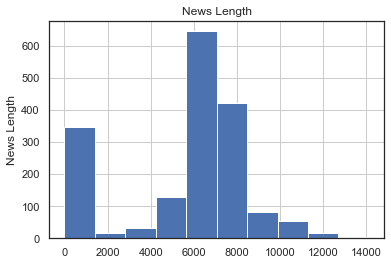

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
sns.set(style="white")
%matplotlib inline

def ChineseCharCount(str_str) :
    count = 0
    if str == type(str_str) :
        for str_tmp in str_str :
            if ord(str_tmp) - ord('0') >= 128 :
                count += 1
    return count
 
print(ChineseCharCount(2))

news['num_words'] = news['text'].apply(ChineseCharCount)
ax=news['num_words'].hist()

ax.set_ylabel('News Length')
ax.set_title('News Length')


Before turning to the NLP aspect, I did the fundamental exploratory data analysis on the data statistically. The first takeaway I gain is that the typical length of the news is 6000-8000. Then I further examined the average news length for each month. 

In [22]:
news['num_words'].idxmin()

25

In [23]:
news=news.sort_values(by=['year','month', 'day'])

In [24]:
news['month'].value_counts()

1     180
11    168
12    164
2     155
3     152
4     147
5     144
10    135
8     125
7     120
6     119
9     119
Name: month, dtype: int64

In [25]:
news=news.drop(index=1318)

In [26]:
keepyear=['2016','2017','2018','2018','2019','2020']
news=news[news['year'].isin(keepyear)]

In [27]:
news['month'] = pd.to_numeric(news['month']) 

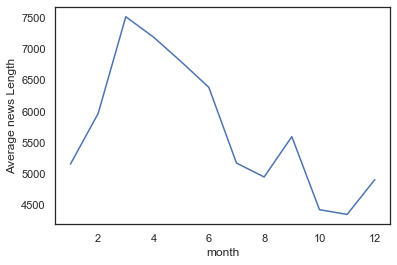

In [28]:
ax= news.groupby('month')['num_words'].mean().plot()
ax.set_ylabel('Average news Length')
import matplotlib.pyplot as plt
plt.show()

As shown above, I found that each year, during March, the news's average length will have a sudden increase. The reason for the peak is that, regularly, the Two Sessions, the most important annual political meetings are held in March. However, in 2020, they are deferred to May due to COVID-19. The Two sessions are always of interest to the researchers, as the government makes the announcement for each year's key economic and international policies, such as the annual GDP growth target. Besides the daily news, in March, the long feature on the two sessions in the news program leads to the sudden jump for the news length.

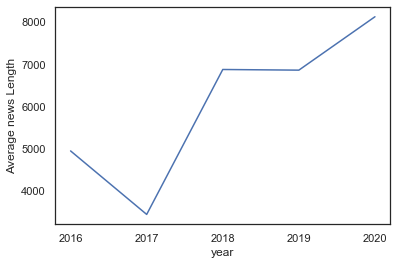

In [29]:
ax= news.groupby('year')['num_words'].mean().plot()
ax.set_ylabel('Average news Length')
import matplotlib.pyplot as plt
plt.show()

In [30]:
before=news[news['year']=='2020']

In [31]:
before['year'].value_counts()

2020    146
Name: year, dtype: int64

In [32]:
news.shape

(1721, 6)

## From token remove the stopwords

In [33]:

stopwords = [line.strip() for line in io.open('/Users/apple/Desktop/中文停用词表.txt', 'r', encoding='utf-8').readlines()]
        


news['cut'] = news['text'].apply(lambda x : [i for i in jieba.cut(x) if i not in stopwords])


news.head(2)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/f2/sg5ytcdn36v_nrhp1b9q3m880000gn/T/jieba.cache
Loading model cost 1.367 seconds.
Prefix dict has been built successfully.


,date,text,year,month,day,num_words,cut
1119,2016-1-1,2016我们来了！世界各国多种形式喜迎2016年央视网消息新闻联播文字版：澳大利亚是全球最先迎来新年的国家之一，悉尼海港大桥的烟花表演已经是延续多年的跨年传统活动，今年的主题是多彩之城”十多万支造型别致新颖的烟花映亮悉尼夜空，现场上百万观众在欢呼声中迎来2016年韩国首尔市在普信阁举行新年敲钟仪式庆祝2016年到来按照传统，钟声要敲响三十三声，代表跨越黑暗”，祈愿国泰民安今年参加敲钟仪式的市民代表，包括了2015年在抗击中东呼吸综合征疫情中作出突出贡献的医务人员新年第一刻，聚集在法国巴黎香榭丽舍大街的人群发出巨大的欢呼声出于安全因素以及对恐袭遇难者的尊重，今年巴黎市政府取消了燃放烟花等环节，缩小迎新年活动规模，并出动了上万名警察和安保人员一些民众表示，他们如常来参加新年活动，就是为了显示不会向恐怖主义低头，并祝福新年会更好2016年南美国家巴西将迎来四年一度的夏季奥运会今年里约热内卢科帕卡巴纳海滩”的跨年庆祝活动主题就是奥运之城·桑巴百年”在壮观的海上焰火表演中，超过200万人共同迎来了2016年除了我们所生活的地球，远在太空的三名国际空间站宇航员也送上了2016年的新年祝福国...,2016,1,1,5617,"[2016, 世界, 各国, 多种形式, 喜迎, 2016, 澳大利亚, 全球, 最先, 迎来, 新年, 国家, 悉尼, 海港, 大桥, 烟花, 表演, 延续, 多年, 跨, 传统, 活动, 主题, 多彩, 城, 十多万, 支, 造型, 别致, 新颖, 烟花, 映亮, 悉尼, 夜空, 现场, 上百万, 观众, 欢呼声, 迎来, 2016, 韩国, 首尔, 市, 普信阁, 举行, 新年, 敲钟, 仪式, 庆祝, 2016, 到来, 传统, 钟声, 敲响, 三十三, 声, 代表, 跨越, 黑暗, 祈愿, 国泰民安, 参加, 敲钟, 仪式, 市民, 代表, 包括, 2015, 抗击, 中东, 呼吸, 综合征, 疫情, 作出, 突出贡献, 医务人员, 新年, 第一, 刻, 聚集, 法国巴黎, 香榭丽舍大街, 人群, 发出, 巨大, 欢呼声, 安全, 因素, 恐袭, 遇难者, 尊重, 巴黎市政府, 取消, 燃放烟花, 环节, 缩小, 迎新年, 活动, 规模, 出动, ...]"
790,2016-1-12,国际联播快讯阿富汗问题四方机制会议发表声明11号，由巴基斯坦阿富汗中国美国参与的阿富汗问题四方机制会议发表联合声明，呼吁阿富汗政府与塔利班立即展开和平对话声明说，与会各方通过了四方机制对话相关工作条款，决定今后定期举行对话声明同时宣布将于1月18号在阿富汗首都喀布尔召开第二轮对话，讨论阿富汗和平进程路线图问题缅甸开启全国和平政治对话缅甸联邦和平会议今天在首都内比都召开，标志着缅甸首轮全国和平政治对话启动缅甸总统吴登盛等政府官员全国民主联盟主席昂山素季和十支少数民族武装领导人及多个国家和组织的观察员参会本轮对话预计持续5天，议题包括政治经济社会安全及土地与自然资源缅甸自1948年独立以来，境内一直存在大小数十支少数民族武装去年10月15号，缅甸政府与8支少数民族武装领导人签署了全国停火协议西班牙公主因涉腐案出庭受审11号，西班牙公主克里斯蒂娜因涉嫌贪腐案出庭受审这是西班牙王室成员首次出现在被告席上克里斯蒂娜是西班牙国王费利佩六世的姐姐，因受丈夫乌丹加林侵占公款案的牵连而被控两项协助逃税罪如果罪名成立，克里斯蒂娜最高可被判八年监禁因担心影响王室形象，西班牙国王费利佩六世已经剥夺了克...,2016,1,12,6941,"[国际, 快讯, 阿富汗, 问题, 四方, 机制, 发表声明, 11, 号, 巴基斯坦, 阿富汗, 中国, 美国, 参与, 阿富汗, 问题, 四方, 机制, 发表, 联合声明, 呼吁, 阿富汗, 政府, 塔利班, 立即, 展开, 和平, 对话, 声明, 说, 与会, 各方, 四方, 机制, 对话, 相关, 工作, 条款, 决定, 今后, 定期, 举行, 对话, 声明, 宣布, 18, 号, 阿富汗, 首都, 喀布尔, 第二轮, 对话, 讨论, 阿富汗, 和平, 进程, 路线图, 问题, 缅甸, 开启, 全国, 和平, 政治, 对话, 缅甸联邦, 和平, 首都, 内比, 标志, 缅甸, 首轮, 全国, 和平, 政治, 对话, 启动, 缅甸, 总统, 吴登盛, 政府, 官员, 全国, 民主联盟, 主席, 昂山, 素季, 十支, 少数民族, 武装, 领导人, 多个, 国家, 组织, 观察员, 参会, 本轮, 对话, 预计, 持续, 天, ...]"


Unlike other languages, in Chinese, there is no spacing between words and more emphasis on the combination of words. Therefore, characters are always being one next to the other in fixed manners, showing up as words. Hence, I did the tokenization to split the whole text into words with Jieba, a Python Chinese word segmentation module; after that, I removed the stopwords, which only have the structural meanings. 

In [34]:
words = []

for word in news['cut']:
    words.extend(word)
    
words

from collections import Counter
from pprint import pprint


counter = Counter(words)

pprint(counter.most_common(30))

[('中国', 31351),
 ('发展', 28750),
 ('习近平', 22325),
 ('国家', 16428),
 ('合作', 16097),
 ('工作', 15195),
 ('建设', 10867),
 ('经济', 10815),
 ('主席', 10334),
 ('国际', 10303),
 ('推动', 9229),
 ('问题', 8863),
 ('加强', 8809),
 ('企业', 8788),
 ('全国', 8776),
 ('全面', 8464),
 ('推进', 8401),
 ('重要', 7845),
 ('我国', 7832),
 ('美国', 7686),
 ('改革', 7658),
 ('—', 7630),
 ('人民', 7357),
 ('进行', 7351),
 ('创新', 7050),
 ('疫情', 7047),
 ('坚持', 6870),
 ('实现', 6797),
 ('总书记', 6736),
 ('世界', 6719)]


## The most common words

In [35]:
df = pd.DataFrame.from_records(counter.most_common(30), columns=['word','count'])
df=df.transpose()
df.to_csv('/Users/apple/Desktop/REFINED.csv',encoding='utf_8_sig')

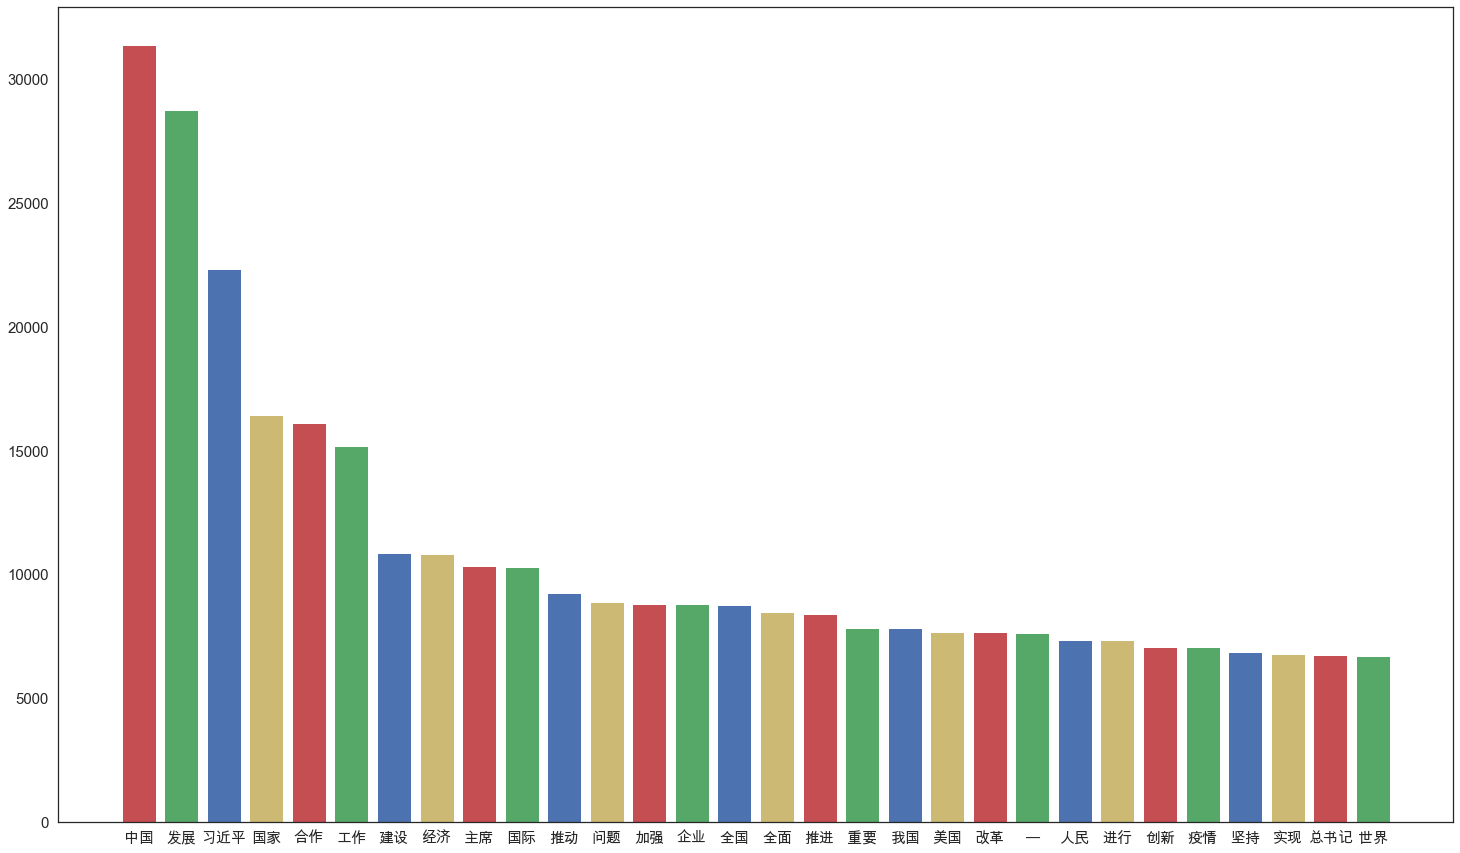

In [36]:
common_token=[word[0] for word in counter.most_common(30)]
common_token_count=[word[1] for word in counter.most_common(30)]
common_tokens_df=pd.DataFrame({'Tokens':common_token,'Count':common_token_count})

import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=[25, 15])
plt.bar(range(len(common_token)), common_token_count,color='rgby',tick_label=common_token)
plt.tick_params(labelsize=15)
plt.show()

From November 2015 to now, the top ten common words are 中国(China), 发展(Development), 习近平(Xi Jinping), 国家(Nation), 合作(Cooperation), 工作(Work), 建设(Construction), 经济(Economic), 主席(Chairman), 国际（International). Looking at the keywords, clearLY that the figure of China and its government that Network News Broadcast is establishing is rather positive, friendly, and cooperative. Since COVID-2019 is undoubtedly the most memorable theme of 2020, I repeated the process of screening keyword for March, which is the most critical period of the combating between the virus. The frequency of 疫情(Epidemics) raised, taking up the fifth place in the list.

In [37]:
march = []
c=news['cut'][news['month']==3].values
for ci in c:
    march.extend(ci)
    


from collections import Counter
from pprint import pprint


counter = Counter(march)

pprint(counter.most_common(10))

[('中国', 3461),
 ('发展', 3453),
 ('习近平', 2624),
 ('工作', 2561),
 ('疫情', 1891),
 ('国家', 1768),
 ('合作', 1433),
 ('主席', 1289),
 ('全国', 1214),
 ('建设', 1205)]


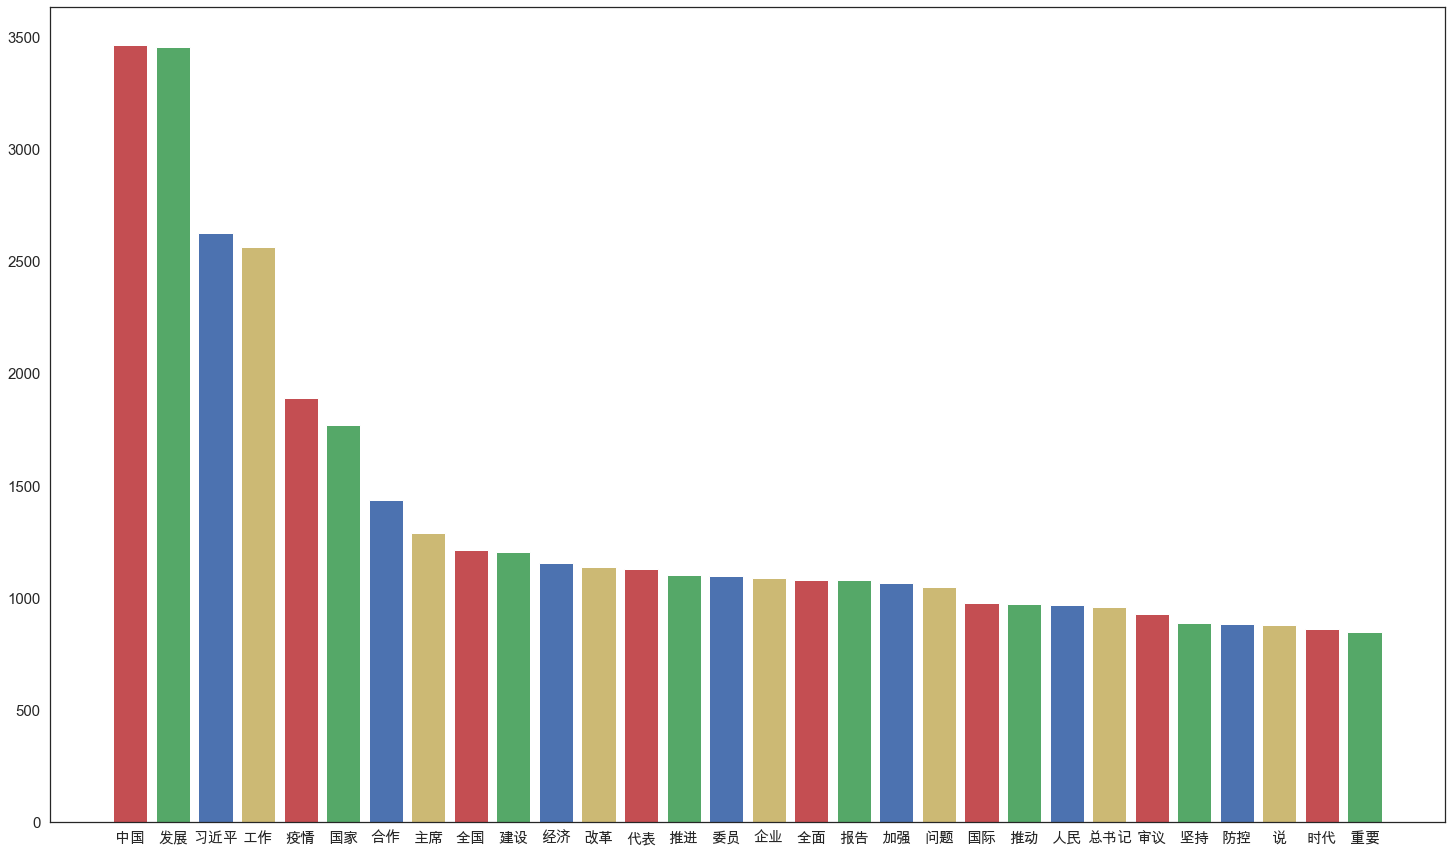

In [38]:
common_token=[word[0] for word in counter.most_common(30)]
common_token_count=[word[1] for word in counter.most_common(30)]
common_tokens_df=pd.DataFrame({'Tokens':common_token,'Count':common_token_count})

import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=[25, 15])
plt.bar(range(len(common_token)), common_token_count,color='rgby',tick_label=common_token)
plt.tick_params(labelsize=15)
plt.show()

In [39]:
news.describe()

,month,num_words
count,1721.000000,1721.000000
mean,6.374201,5689.256827
std,3.622364,2986.722804
min,1.000000,0.000000
25%,3.000000,5129.000000
50%,6.000000,6573.000000
75%,10.000000,7372.000000
max,12.000000,14110.000000


In [40]:
def process_words(x):
    
    stop_words = [line.strip() for line in io.open('/Users/apple/Desktop/中文停用词表.txt', 'r', encoding='utf-8').readlines()]
        
    seg = jieba.cut(x, cut_all=False) 
        
        
    text_split_no = []
    
    for words in seg: 
             if words not in stop_words: 
             
                  text_split_no.append(words)
                   
                   

 
    return ','.join(text_split_no)

In [41]:
news['tokenized']=news['text'].apply(process_words)
news.head(2)

def create_xi_count(row):
    xi_names = ['习近平', '习主席', '习书记', '习总书记']
    return 100 *  ((row.count(xi_names[0])/len(row)) + 
                  (row.count(xi_names[1])/len(row)) +
                  (row.count(xi_names[2])/len(row)) +
                  (row.count(xi_names[3])/len(row))) 

news['xi_count'] = news['tokenized'].apply(create_xi_count)



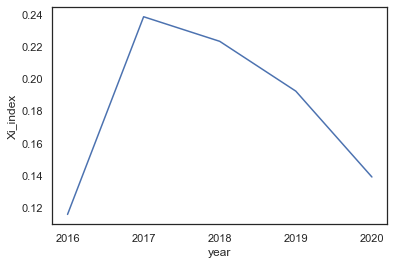

In [42]:
ax= news.groupby('year')['xi_count'].mean().plot()
ax.set_ylabel('Xi_index')
import matplotlib.pyplot as plt
plt.show()


2017 is a very different year in the sense that the index of the words related to Xi Jinping increased dramatically and arrived at its pinnacle. A major political determination is the reason for the ascendancy. At the 19h National Congress of Communist Party of China(CPC), Xi announced that socialism with Chinese characteristics had entered a new era with a more than 3 hours speech on Network News Broadcast. Internationally, it is viewed as the signal that China is transforming from being a large country to a strong one. 

## Topic Model- LDA

In [43]:
n_features = 1000

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(news.tokenized)

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

In [46]:

lda = LatentDirichletAllocation(n_components=5, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [47]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [49]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [50]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.033726  0.003175       1        1  32.162679
0     -0.135746  0.080860       2        1  21.024658
1     -0.076655 -0.146676       3        1  20.216697
2     -0.020464  0.058506       4        1  16.217424
4      0.199139  0.004134       5        1  10.378542, topic_info=        Term         Freq        Total Category  logprob  loglift
743       疫情  6900.000000  6900.000000  Default  30.0000  30.0000
950       防控  3603.000000  3603.000000  Default  29.0000  29.0000
744       病例  2736.000000  2736.000000  Default  28.0000  28.0000
815       肺炎  1849.000000  1849.000000  Default  27.0000  27.0000
161       会见  4374.000000  4374.000000  Default  26.0000  26.0000
598       新冠  1789.000000  1789.000000  Default  25.0000  25.0000
421       审议  2633.000000  2633.000000  Default  24.0000  24.0000
759       确诊  1616.000000  1616.000000  Default  23.0000  23.0000
374       复工  1393.000000  1393.000000  Default  22.0000  22.0000
832       草案  2077.000000  2077.000000  Default  21.0000  21.0000
401       委员  2744.000000  2744.000000  Default  20.0000  20.0000
664       武汉  1445.000000  1445.000000  Default  19.0000  19.0000
553       抗疫  1098.000000  1098.000000  Default  18.0000  18.0000
520       患者  1306.000000  1306.000000  Default  17.0000  17.0000
786       累计  1703.000000  1703.000000  Default  16.0000  16.0000
601       新增  1592.000000  1592.000000  Default  15.0000  15.0000
200  全国人大常委会  2145.000000  2145.000000  Default  14.0000  14.0000
75        两国  2648.000000  2648.000000  Default  13.0000  13.0000
201     全国政协  2368.000000  2368.000000  Default  12.0000  12.0000
711       湖北  1451.000000  1451.000000  Default  11.0000  11.0000
864       论坛  2141.000000  2141.000000  Default  10.0000  10.0000
279       医院  1631.000000  1631.000000  Default   9.0000   9.0000
12      2016  1894.000000  1894.000000  Default   8.0000   8.0000
339       周年  2846.000000  2846.000000  Default   7.0000   7.0000
450       峰会  2163.000000  2163.000000  Default   6.0000   6.0000
281      十三届  1223.000000  1223.000000  Default   5.0000   5.0000
372       复产   817.000000   817.000000  Default   4.0000   4.0000
425       宪法  1443.000000  1443.000000  Default   3.0000   3.0000
199     全国人大  1532.000000  1532.000000  Default   2.0000   2.0000
528       愿同  1991.000000  1991.000000  Default   1.0000   1.0000
602       新春   509.466468   527.197233   Topic1  -6.4427   1.1002
618       春节   889.761063   966.941100   Topic1  -5.8851   1.0512
247       出行   472.520101   532.032526   Topic1  -6.5179   1.0157
710       游客  1017.121871  1153.527269   Topic1  -5.7513   1.0085
52       万人次   474.576755   554.969945   Topic1  -6.5136   0.9779
398       如今   716.775978   839.894153   Topic1  -6.1013   0.9759
607       旅客   711.605211   853.867849   Topic1  -6.1085   0.9521
707       深圳   529.322038   643.754767   Topic1  -6.4044   0.9386
251       列车   444.345792   541.865848   Topic1  -6.5794   0.9359
644       村里   548.626547   677.306167   Topic1  -6.3686   0.9237
643       村民  1170.520592  1446.798180   Topic1  -5.6108   0.9225
809       老人   525.204840   652.130412   Topic1  -6.4122   0.9179
109      乌克兰   414.651652   521.324910   Topic1  -6.6486   0.9054
391       大桥   459.321063   588.120775   Topic1  -6.5463   0.8872
434       导弹   536.197439   690.491573   Topic1  -6.3915   0.8815
997       高铁   784.218078  1012.921597   Topic1  -6.0113   0.8785
111       乡村  1170.320213  1523.888299   Topic1  -5.6110   0.8704
260       制裁   575.387163   759.189613   Topic1  -6.3210   0.8572
479       广州   366.249047   496.545728   Topic1  -6.7727   0.8300
746       百姓   468.107731   639.119957   Topic1  -6.5273   0.8230
409       孩子   460.747584   631.138460   Topic1  -6.5432   0.8197
585       救援   685.126469   946.807591   Topic1  -6.1464   0.8109
154       伊核   393.186299   544.841064   Topic1  -6.7017   0.8082
622       景区   

Then I extracted the latent topics by deploying Latent Dirichlet Allocation(LDA) model that is commonly adopted on the topic extraction of English texts. The LDA model is a generative probabilistic model that detects topics from the distribution over arbitrary blending words. I requested the model to find five topics among the content, and here are the outcomes.

Topic 1 and Topic 4 are close in the Intertopic Distance Map which can be told from their representative terms including 叙利亚（Syria),伊朗（Iran), 武装(Miliary), 死亡(Death), 袭击(Attack), 极端(extremist). Thus, these two topics are international news identified with Violence. 

The keywords for topic 2 are 会见（Meeting),周年(Anniversary),两国(Nations), 命运共同体(A community of shared future), 友好(Friendly) demonstrating that this topic is about the China's diplomatic relations.

Topic 3 contains words, such as 审议(Deliberation), 委员(Commissioners), 草案(Draft), 代表团(Delegation), therefore, it is conceivable to reason that it that it about polictical meeting like the Two Sessions.

With regards to topic 5, the common terms become to 疫情(Epidemics),防控(Prevention and Control),病例(Cases of disease), 肺炎(Pneumonia), clarifying that the theme is COVID-2019.

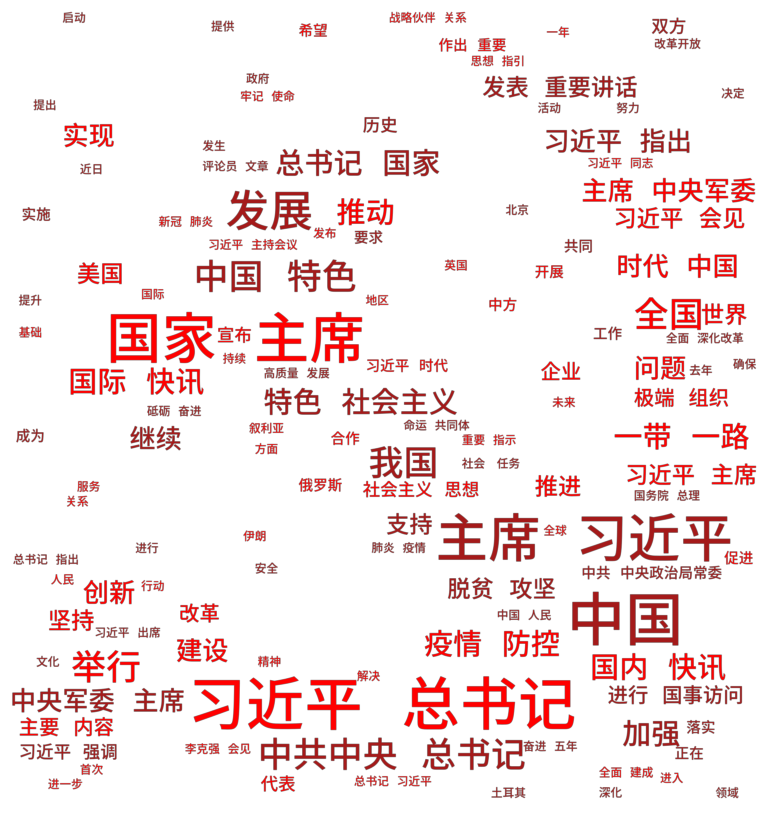

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from PIL import Image
from matplotlib import colors

mask = np.array(Image.open('/Users/apple/Desktop/greatwall.png'))
color_list=['#FF0000','#a41a1a']#建立颜色数组
colormap=colors.ListedColormap(color_list)
 
wordcloud = word_cloud=WordCloud(
    font_path="/Users/apple/Desktop/SourceHanMono-Medium.otf",
    background_color=None,
    mode="RGBA",
    prefer_horizontal=1,
    mask=mask,
    height=800,
    width=500,
    scale=10,
    colormap=colormap,#设置颜色
    margin=2
).generate(str(news['tokenized']))
plt.figure(figsize=[25, 15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [52]:
import jieba
import gensim



/Users/apple/PycharmProjects/PRACTICE/venv/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [53]:
texts_list=[]
for item in news['cut']:
    words=[word for word in item]
    texts_list.append(words)

In [54]:
import gensim
dictionary=gensim.corpora.Dictionary(texts_list)
corpus = [dictionary.doc2bow(doc) for doc in texts_list]

length of dictionary is the total # of words in the document
length of corpus is the len(news)
corpus is the vector for each day's new 

In [55]:
lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=5,
                           id2word=dictionary,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)


In [111]:
lda_train4.print_topics(20,num_words=15)

[(0,
  '0.020*"疫情" + 0.010*"防控" + 0.007*"病例" + 0.006*"中国" + 0.006*"企业" + 0.005*"工作" + 0.005*"肺炎" + 0.005*"新冠" + 0.005*"复工" + 0.004*"确诊" + 0.004*"国家" + 0.004*"患者" + 0.004*"武汉" + 0.003*"湖北" + 0.003*"医院"'),
 (1,
  '0.005*"发展" + 0.004*"中国" + 0.003*"我国" + 0.003*"企业" + 0.003*"国家" + 0.003*"号" + 0.003*"全国" + 0.003*"工作" + 0.003*"进行" + 0.003*"改革" + 0.002*"问题" + 0.002*"经济" + 0.002*"建设" + 0.002*"创新" + 0.002*"地区"'),
 (2,
  '0.015*"合作" + 0.015*"中国" + 0.014*"发展" + 0.013*"习近平" + 0.007*"主席" + 0.007*"国家" + 0.006*"中方" + 0.005*"关系" + 0.005*"推动" + 0.005*"国际" + 0.005*"共同" + 0.005*"加强" + 0.005*"经济" + 0.004*"总统" + 0.004*"会见"'),
 (3,
  '0.014*"中国" + 0.007*"香港" + 0.006*"美国" + 0.004*"—" + 0.004*"活动" + 0.004*"70" + 0.003*"时代" + 0.003*"国家" + 0.003*"习近平" + 0.003*"发展" + 0.003*"国际" + 0.003*"全国" + 0.003*"主题" + 0.003*"周年" + 0.003*"总书记"'),
 (4,
  '0.011*"工作" + 0.010*"发展" + 0.010*"习近平" + 0.007*"中国" + 0.006*"坚持" + 0.005*"全面" + 0.005*"国家" + 0.005*"建设" + 0.004*"党" + 0.004*"推进" + 0.004*"人民" + 0.004*"改革" + 0.004*"社会主义" + 0.00

In [56]:
for i in range(len(news)):
    top_topics = lda_train4.get_document_topics(corpus, minimum_probability=0.0)


In [57]:
x=np.array(top_topics)

In [75]:
news['topic1']=x[:,0,1]
news['topic2']=x[:,1,1]
news['topic3']=x[:,2,1]
news['topic4']=x[:,3,1]
news['topic5']=x[:,4,1]

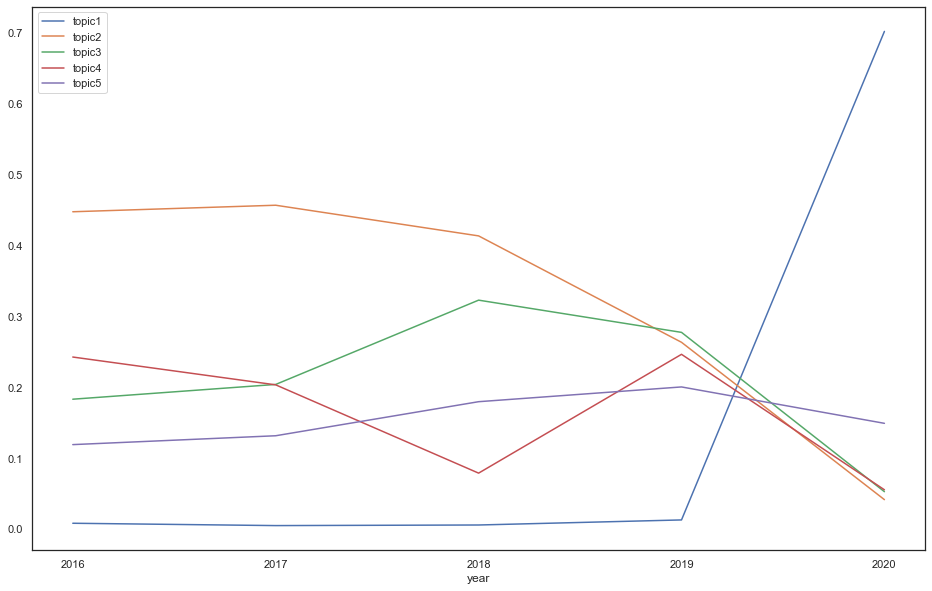

In [116]:
fig, ax = plt.subplots(1,1,figsize=(16, 10))
news.groupby('year')['topic1'].mean().plot()
news.groupby('year')['topic2'].mean().plot()
news.groupby('year')['topic3'].mean().plot()
news.groupby('year')['topic4'].mean().plot()
news.groupby('year')['topic5'].mean().plot()

plt.legend()


In the final step, I assembled another LDA to locate another five common topics. COVID-19 is topic 1 in this model. Then I assigned these five topics to each day's news to follow their changes from 2016 to 2020. Intuitively, topic 1 has a sudden rise in 2020.